# Library import and data preprocessing

**Importing the libraries**

In [1]:
import torch
print(torch.cuda.is_available())

True


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os

**Data Transformation**

Defines a set of transformations to be applied to images for data augmentation and normalization during the training, validation, and testing phases.

In [4]:
# Define data transformations for data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

Importing the annotated and labeled dataset

In [ ]:
# Define the data directory
data_dir = '/home/pushan/Desktop/ML/ML_PROJECT/4628934/roi_extracted'

# Create data loaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
#image_datasets

**Dataloader**

for loading and batching image datasets and retrieves the dataset sizes and class names.

In [6]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
print(dataset_sizes)

class_names = image_datasets['train'].classes
class_names

{'train': 6452, 'val': 806, 'test': 809}


['cocci', 'healthy', 'ncd', 'salmo']

# Classification Model

**Resnet50**

The pretrained model used for prediction by freezing all the layer except the final layer(classification layer) allowing model to update weight of the classification layer according to the given dataset.


In [7]:
# Load the pre-trained EfficientNet model
model = models.efficientnet_b0(pretrained=True)  # Use efficientnet_b0; replace with other variants if needed

# Freeze all layers except the classifier
for name, param in model.named_parameters():
    if "classifier" in name:  # Enable training for classifier layers
        param.requires_grad = True
    else:  # Freeze all other layers
        param.requires_grad = False

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, momentum=0.9)

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"EfficientNet is successfully loaded and moved to {device}")

/home/pushan/anaconda3/envs/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pushan/anaconda3/envs/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet is successfully loaded and moved to cuda:0


**Training the model**

Using transfer learning on resnet50 model to use it for classification of poultry disease given the fecal images



In [8]:
from tqdm import tqdm
import torch

# Early stopping parameters
patience = 5
best_loss = float('inf')
early_stop_counter = 0

# Lists to store metrics
val_losses = []
val_accuracies = []
train_losses = []
train_accuracies = []

# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 20)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        # Wrap the dataloader with tqdm
        dataloader_tqdm = tqdm(dataloaders[phase], desc=f'{phase.capitalize()} Phase')

        for inputs, labels in dataloader_tqdm:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Store metrics in the respective lists
        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc.item())
        elif phase == 'val':
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc.item())

            # Early stopping logic
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                early_stop_counter = 0  # Reset counter if validation loss improves
            else:
                early_stop_counter += 1

    # Check if early stopping is triggered
    if early_stop_counter >= patience:
        print(f'Early stopping triggered at epoch {epoch + 1}.')
        break

print("Training complete!")

# Display stored metrics
print("Train Losses:", train_losses)
print("Train Accuracies:", train_accuracies)
print("Validation Losses:", val_losses)
print("Validation Accuracies:", val_accuracies)

Epoch 1/15
--------------------


Train Phase:   0%|          | 0/1613 [00:00<?, ?it/s]

Train Phase: 100%|██████████| 1613/1613 [03:42<00:00,  7.27it/s]


Train Loss: 1.1874 Acc: 0.6562


Val Phase: 100%|██████████| 202/202 [00:25<00:00,  7.81it/s]


Val Loss: 1.1537 Acc: 0.7928
Epoch 2/15
--------------------


Train Phase: 100%|██████████| 1613/1613 [03:18<00:00,  8.12it/s]


Train Loss: 0.7748 Acc: 0.7212


Val Phase: 100%|██████████| 202/202 [00:26<00:00,  7.73it/s]


Val Loss: 1.2270 Acc: 0.8127
Epoch 3/15
--------------------


Train Phase: 100%|██████████| 1613/1613 [03:15<00:00,  8.25it/s]


Train Loss: 0.7334 Acc: 0.7299


Val Phase: 100%|██████████| 202/202 [00:27<00:00,  7.37it/s]


Val Loss: 2.1238 Acc: 0.8077
Epoch 4/15
--------------------


Train Phase: 100%|██████████| 1613/1613 [03:19<00:00,  8.08it/s]


Train Loss: 0.7046 Acc: 0.7379


Val Phase: 100%|██████████| 202/202 [00:25<00:00,  7.81it/s]


Val Loss: 1.0222 Acc: 0.7990
Epoch 5/15
--------------------


Train Phase: 100%|██████████| 1613/1613 [03:13<00:00,  8.34it/s]


Train Loss: 0.7106 Acc: 0.7396


Val Phase: 100%|██████████| 202/202 [00:25<00:00,  7.93it/s]


Val Loss: 1.8533 Acc: 0.8127
Epoch 6/15
--------------------


Train Phase: 100%|██████████| 1613/1613 [03:14<00:00,  8.30it/s]


Train Loss: 0.6722 Acc: 0.7492


Val Phase: 100%|██████████| 202/202 [00:24<00:00,  8.20it/s]


Val Loss: 0.9477 Acc: 0.8139
Epoch 7/15
--------------------


Train Phase: 100%|██████████| 1613/1613 [03:17<00:00,  8.18it/s]


Train Loss: 0.6748 Acc: 0.7523


Val Phase: 100%|██████████| 202/202 [00:26<00:00,  7.63it/s]


Val Loss: 1.6828 Acc: 0.7953
Epoch 8/15
--------------------


Train Phase: 100%|██████████| 1613/1613 [03:46<00:00,  7.12it/s]


Train Loss: 0.6631 Acc: 0.7539


Val Phase: 100%|██████████| 202/202 [00:28<00:00,  7.05it/s]


Val Loss: 0.7364 Acc: 0.8275
Epoch 9/15
--------------------


Train Phase: 100%|██████████| 1613/1613 [03:26<00:00,  7.82it/s]


Train Loss: 0.6544 Acc: 0.7554


Val Phase: 100%|██████████| 202/202 [00:30<00:00,  6.71it/s]


Val Loss: 0.6878 Acc: 0.8561
Epoch 10/15
--------------------


Train Phase: 100%|██████████| 1613/1613 [03:49<00:00,  7.04it/s]


Train Loss: 0.6518 Acc: 0.7641


Val Phase: 100%|██████████| 202/202 [00:28<00:00,  7.17it/s]


Val Loss: 0.8069 Acc: 0.8610
Epoch 11/15
--------------------


Train Phase: 100%|██████████| 1613/1613 [03:24<00:00,  7.89it/s]


Train Loss: 0.6507 Acc: 0.7607


Val Phase: 100%|██████████| 202/202 [00:26<00:00,  7.59it/s]


Val Loss: 0.7651 Acc: 0.8337
Epoch 12/15
--------------------


Train Phase: 100%|██████████| 1613/1613 [03:23<00:00,  7.94it/s]


Train Loss: 0.6682 Acc: 0.7511


Val Phase: 100%|██████████| 202/202 [00:27<00:00,  7.35it/s]


Val Loss: 5.2795 Acc: 0.8561
Epoch 13/15
--------------------


Train Phase: 100%|██████████| 1613/1613 [03:21<00:00,  7.99it/s]


Train Loss: 0.6447 Acc: 0.7626


Val Phase: 100%|██████████| 202/202 [00:27<00:00,  7.44it/s]


Val Loss: 1.8043 Acc: 0.8486
Epoch 14/15
--------------------


Train Phase: 100%|██████████| 1613/1613 [03:20<00:00,  8.03it/s]


Train Loss: 0.6542 Acc: 0.7539


Val Phase: 100%|██████████| 202/202 [00:26<00:00,  7.58it/s]

Val Loss: 2.0497 Acc: 0.8610
Early stopping triggered at epoch 14.
Training complete!
Train Losses: [1.1873823005431237, 0.774805381827135, 0.7334141588775049, 0.7046395281412895, 0.710645253699035, 0.6721630715531218, 0.6747874623419738, 0.6630673840900644, 0.6544466923162461, 0.6517813148557844, 0.6506826962342617, 0.6681650721901647, 0.6447074265223313, 0.6541704144478953]
Train Accuracies: [0.6562306261624302, 0.7211717296962182, 0.7298512089274644, 0.7379107253564786, 0.7396156230626162, 0.7492250464972101, 0.7523248605083694, 0.7538747675139491, 0.7554246745195288, 0.7641041537507749, 0.7606943583384996, 0.7510849349039057, 0.7625542467451952, 0.7538747675139491]
Validation Losses: [1.1536599978360882, 1.2270230599228413, 2.1238162454319354, 1.022169532023241, 1.8532571012926087, 0.9476720220120461, 1.682815766918748, 0.7363668879397011, 0.6878172221313931, 0.806870997922666, 0.7651440699402215, 5.279542313495804, 1.8042947908784852, 2.0496631646043535]
Validation Accuracies: [0.

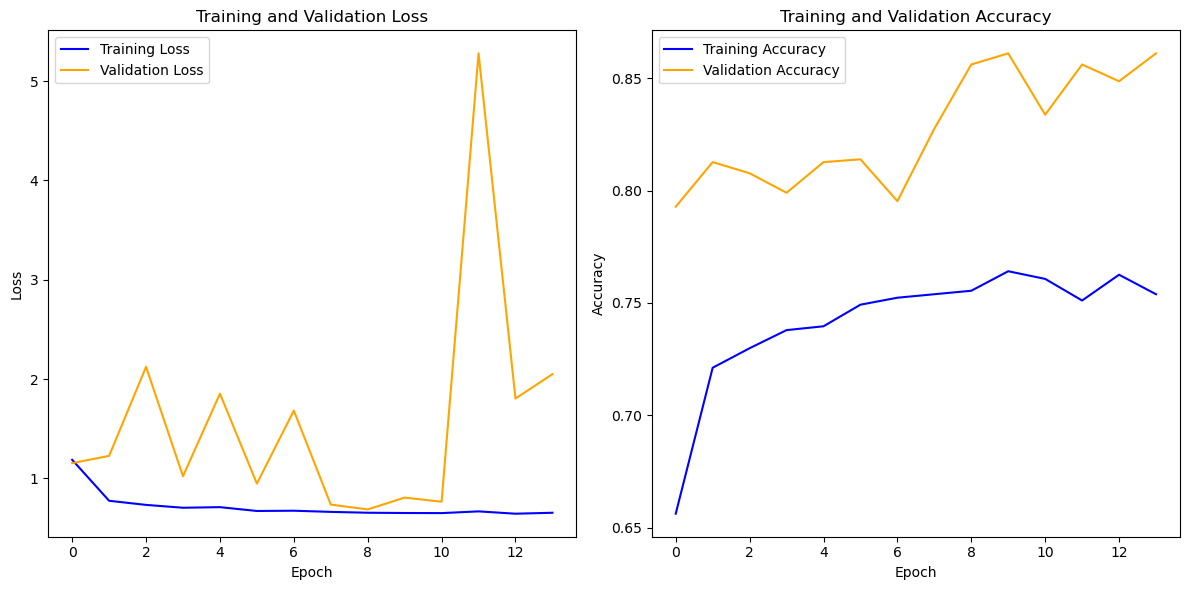

In [13]:
import matplotlib.pyplot as plt

# Plot losses
plt.figure(figsize=(12, 6))

# Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()

**Model Evaluation**

Evaluating the model's performance on the test dataset to achieve the test accuracy > 92%

In [14]:
!pip install scikit-learn

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()

# Initialize test accuracy and loss
test_loss = 0.0
correct_predictions = 0

# Initialize lists to store predictions and true labels for the confusion matrix
all_preds = []
all_labels = []

# Turn off gradients for validation (saves memory and computations)
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Calculate accuracy
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data)
        test_loss += loss.item() * inputs.size(0)

        # Collect all predictions and true labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate average loss and accuracy
test_loss = test_loss / dataset_sizes['test']
test_acc = correct_predictions.double() / dataset_sizes['test']

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

Test Loss: 0.6327, Test Accuracy: 0.8294


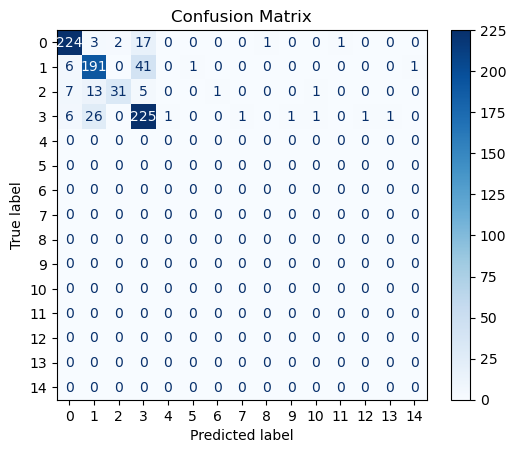

In [16]:
# Compute and display the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [18]:
torch.save(model.state_dict(), '/home/pushan/Desktop/ML/ML_PROJECT/4628934/final_files/efficientNet.pth')

#An utility function
This is an utility function to have prediction using the trained model and a given image using *image_path* *italicised text*

In [20]:
import torch
from torchvision import models
import torch.nn as nn

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained EfficientNet model
model = models.efficientnet_b0(pretrained=True)  # EfficientNet B0 as an example
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1000)  # Adjust to match the original model's output units (1000 classes for ImageNet)
model.load_state_dict(torch.load('/home/pushan/Desktop/ML/ML_PROJECT/4628934/final_files/efficientNet.pth', map_location=device))
model = model.to(device)  # Move the model to GPU or CPU
model.eval()

# Create a new EfficientNet model with the correct final layer
new_model = models.efficientnet_b0(pretrained=True)  # EfficientNet B0 as an example
new_model.classifier[1] = nn.Linear(new_model.classifier[1].in_features, 1000)  # Adjust to match the desired output units (2 classes)
new_model = new_model.to(device)  # Move the new model to GPU or CPU

# Copy the weights and biases from the loaded model to the new model
new_model.classifier[1].weight.data = model.classifier[1].weight.data[0:2].to(device)  # Copy only the first 2 output units
new_model.classifier[1].bias.data = model.classifier[1].bias.data[0:2].to(device)  # Copy only the first 2 output units

/tmp/ipykernel_159902/2654680613.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/home/pushan/Desktop/ML/ML_PROJECT/4628934/final_file

**Preprocessing**

the image is being preprocessed similary as of train data before being fed up for the prediction

In [22]:
from PIL import Image
image_path = '/home/pushan/Desktop/ML/ML_PROJECT/4628934/roi_extracted/val/salmo/salmo.2101.jpg'  # Replace with the path to your image
image = Image.open(image_path)

# Use the 'test' transform from data_transforms
preprocess = data_transforms['test']
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

# Ensure the tensor is moved to the appropriate device if necessary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_batch = input_batch.to(device)

# Print the input_batch shape to verify
print("Input batch shape:", input_batch.shape)


Input batch shape: torch.Size([1, 3, 224, 224])


In [23]:
# Perform inference
with torch.no_grad():
    output = model(input_batch)

# Get the predicted class
_, predicted_class = output.max(1)

# Map the predicted class to the class name
class_names = ['cocci', 'healthy', 'ncd', 'salmo']  # Make sure these class names match your training data
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')

The predicted class is: salmo


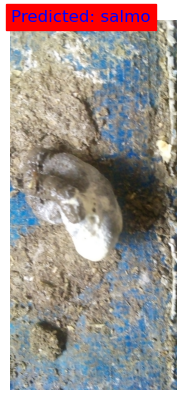

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='blue', backgroundcolor='red')
plt.show()